In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(11111111)

In [ ]:
mean_return = 0.01 * np.random.randn(2)
mean_return

array([-0.00798242,  0.00181554])

In [ ]:
rho = 0.01 * np.random.randn()
rho

0.007129547452251222

In [ ]:
sigmas = np.exp(np.random.randn(2))
sigmas

array([2.83423006, 0.50425457])

In [ ]:
cov = np.diag(sigmas**2)
cov

array([[8.03286002, 0.        ],
       [0.        , 0.25427267]])

In [ ]:
sigma12 = sigmas[0] * sigmas[1] * rho
cov[0,1] = sigma12
cov[1,0] = sigma12
cov

array([[8.03286002, 0.01018936],
       [0.01018936, 0.25427267]])

In [ ]:
def softmax(w):
  a = np.exp(w)
  return a / a.sum()

In [ ]:
N = 1000
returns = np.zeros(N)
risks = np.zeros(N)
for i in range(N):
  w = softmax(np.random.randn(2))
  ret = mean_return.dot(w)
  risk = np.sqrt(w.dot(cov).dot(w))
  returns[i] = ret
  risks[i] = risk

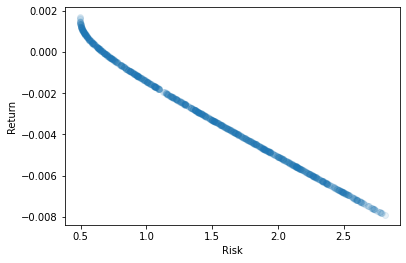

In [ ]:
plt.scatter(risks, returns, alpha=0.1);
plt.xlabel("Risk");
plt.ylabel("Return");

In [ ]:
N = 1000
returns = np.zeros(N)
risks = np.zeros(N)
for i in range(N):
  x = np.random.random()
  w = np.array([x, 1-x]) # positive-only
  ret = mean_return.dot(w)
  risk = np.sqrt(w.dot(cov).dot(w))
  returns[i] = ret
  risks[i] = risk

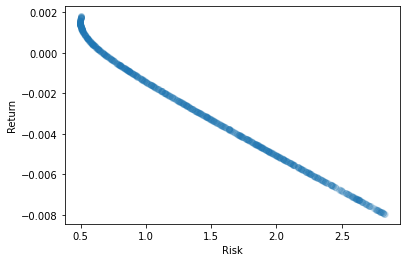

In [ ]:
plt.scatter(risks, returns, alpha=0.1);
plt.xlabel("Risk");
plt.ylabel("Return");

In [ ]:
N = 1000
returns = np.zeros(N)
risks = np.zeros(N)
for i in range(N):
  x = np.random.random() - 0.5
  w = np.array([x, 1-x]) # short-selling allowed
  ret = mean_return.dot(w)
  risk = np.sqrt(w.dot(cov).dot(w))
  returns[i] = ret
  risks[i] = risk

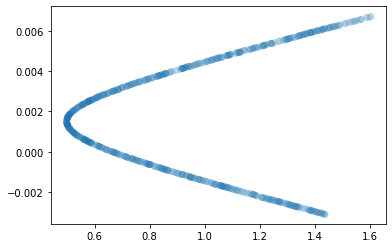

In [ ]:
plt.scatter(risks, returns, alpha=0.1);

## 3-Asset Portfolio

In [ ]:
mean_return = 0.01 * np.random.randn(3)
mean_return

array([-0.00064955, -0.00479921,  0.00296115])

In [ ]:
sigmas = np.exp(np.random.randn(3))
sigmas

array([1.06431534, 0.40268065, 1.58583079])

In [ ]:
rhos = 0.01 * np.random.randn(3)
rhos

array([-0.00528151,  0.01889692, -0.00046375])

In [ ]:
cov = np.array([
  [sigmas[0]**2, rhos[0]*sigmas[0]*sigmas[1], rhos[1]*sigmas[0]*sigmas[2]],
  [rhos[0]*sigmas[0]*sigmas[1], sigmas[1]**2, rhos[2]*sigmas[1]*sigmas[2]],
  [rhos[1]*sigmas[0]*sigmas[2], rhos[2]*sigmas[1]*sigmas[2], sigmas[2]**2],
])
cov

array([[ 1.13276715e+00, -2.26354366e-03,  3.18946690e-02],
       [-2.26354366e-03,  1.62151710e-01, -2.96140881e-04],
       [ 3.18946690e-02, -2.96140881e-04,  2.51485929e+00]])

In [ ]:
N = 1000
returns = np.zeros(N)
risks = np.zeros(N)
for i in range(N):
  x1, x2 = np.random.random(2) - 0.5
  w = np.array([x1, x2, 1 - x1 - x2]) # short-selling allowed
  np.random.shuffle(w)
  ret = mean_return.dot(w)
  risk = np.sqrt(w.dot(cov).dot(w))
  returns[i] = ret
  risks[i] = risk

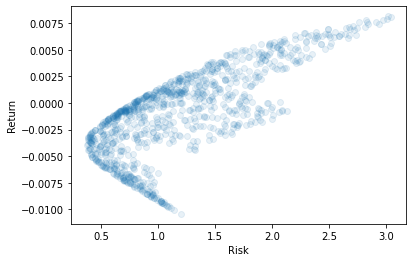

In [ ]:
plt.scatter(risks, returns, alpha=0.1);
plt.xlabel("Risk");
plt.ylabel("Return");

## Max and Min Return




In [ ]:
from scipy.optimize import linprog

In [ ]:
D = len(mean_return)

In [ ]:
A_eq = np.ones((1, D))
b_eq = np.ones(1)

In [ ]:
### NOTE: The bounds are by default (0, None) unless otherwise specified.
# bounds = None
bounds = [(-0.5, None)]*D
bounds

[(-0.5, None), (-0.5, None), (-0.5, None)]

In [ ]:
# minimize
res = linprog(mean_return, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
res

     con: array([-7.79154519e-12])
     fun: -0.010754214043607433
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([-0.5,  2. , -0.5])

In [ ]:
min_return = res.fun

In [ ]:
# maximize
res = linprog(-mean_return, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
res

     con: array([-9.65960645e-12])
     fun: -0.008646673062626271
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([-0.5, -0.5,  2. ])

In [ ]:
max_return = -res.fun

In [ ]:
min_return, max_return

(-0.010754214043607433, 0.008646673062626271)

## Mean-Variance Optimal Portfolios

In [ ]:
N = 100
target_returns = np.linspace(min_return, max_return, num=N)

In [ ]:
from scipy.optimize import minimize

In [ ]:
def get_portfolio_variance(weights):
  return weights.dot(cov).dot(weights)

In [ ]:
def target_return_constraint(weights, target):
  return weights.dot(mean_return) - target

In [ ]:
def portfolio_constraint(weights):
  return weights.sum() - 1

In [ ]:
constraints = [
    {
        'type': 'eq',
        'fun': target_return_constraint,
        'args': [target_returns[0]], # will be updated in loop
    },
    {
        'type': 'eq',
        'fun': portfolio_constraint,
    }
]

In [ ]:
# check if it works
res = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D) / D, # uniform
    method='SLSQP',
    constraints=constraints,
)
res

     fun: 1.5798211171184269
     jac: array([-1.10493316,  0.64639013, -2.62879078])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([-0.46920445,  1.98567162, -0.51646717])

In [ ]:
# Let's limit the magnitude of the weights
res = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D) / D, # uniform
    method='SLSQP',
    constraints=constraints,
    bounds=bounds,
)
res

     fun: 1.5815800905221253
     jac: array([-1.1737159 ,  0.65116651, -2.5479385 ])
 message: 'Optimization terminated successfully.'
    nfev: 10
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([-0.49999997,  1.99999997, -0.5       ])

In [ ]:
optimized_risks = []
for target in target_returns:
  # set target return constraint
  constraints[0]['args'] = [target]

  res = minimize(
      fun=get_portfolio_variance,
      x0=np.ones(D) / D, # uniform
      method='SLSQP',
      constraints=constraints,
      bounds=bounds,
  )
  optimized_risks.append(np.sqrt(res.fun))
  if res.status != 0:
    print(res)

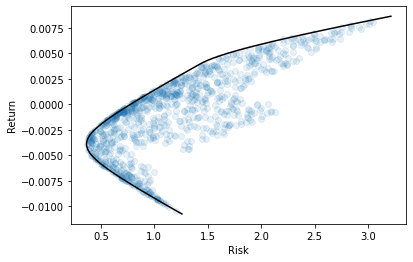

In [ ]:
plt.scatter(risks, returns, alpha=0.1);
plt.plot(optimized_risks, target_returns, c='black');
plt.xlabel("Risk");
plt.ylabel("Return");

In [ ]:
# do it again but with >= constraint on target return
constraints_ineq = [
    {
        'type': 'ineq',
        'fun': target_return_constraint,
        'args': [target_returns[0]], # will be updated in loop
    },
    {
        'type': 'eq',
        'fun': portfolio_constraint,
    }
]

optimized_risks = []
optimized_returns = []
for target in target_returns:
  # set target return constraint
  constraints_ineq[0]['args'] = [target]

  res = minimize(
      fun=get_portfolio_variance,
      x0=np.ones(D) / D, # uniform
      method='SLSQP',
      constraints=constraints_ineq,
      bounds=bounds,
  )
  optimized_risks.append(np.sqrt(res.fun))
  optimized_returns.append(mean_return.dot(res.x))
  if res.status != 0:
    print(res)

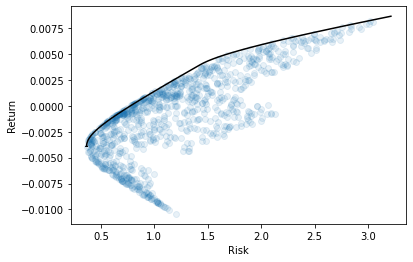

In [ ]:
plt.scatter(risks, returns, alpha=0.1);
plt.plot(optimized_risks, optimized_returns, c='black');
plt.xlabel("Risk");
plt.ylabel("Return");

## Sharpe Ratio



In [ ]:
def neg_sharpe_ratio(weights):
  mean = weights.dot(mean_return)
  sd = np.sqrt(weights.dot(cov).dot(weights))
  return -mean / sd

In [ ]:
max_sr = float('-inf')
max_sr_weights = None
for target in target_returns:
  # set target return constraint
  constraints[0]['args'] = [target]

  res = minimize(
      fun=neg_sharpe_ratio,
      x0=np.ones(D) / D, # uniform
      method='SLSQP',
      constraints={
        'type': 'eq',
        'fun': portfolio_constraint,
    },
    bounds=bounds,
  )
  if -res.fun > max_sr:
    max_sr = -res.fun
    max_sr_weights = res.x
max_sr, max_sr_weights

(0.002968491900870095, array([ 0.35458401, -0.5       ,  1.14541599]))

In [ ]:
res = minimize(
    fun=neg_sharpe_ratio,
    x0=np.ones(D) / D, # uniform
    method='SLSQP',
    constraints={
        'type': 'eq',
        'fun': portfolio_constraint,
    },
    bounds=bounds,
)
res

     fun: -0.002968491900870095
     jac: array([0.00071834, 0.00249228, 0.00086556])
 message: 'Optimization terminated successfully.'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.35458401, -0.5       ,  1.14541599])

In [ ]:
-res.fun * np.sqrt(252)

0.04712334803167004

In [ ]:
w = res.x
sr_return = w.dot(mean_return)
sr_risk = np.sqrt(w.dot(cov).dot(w))

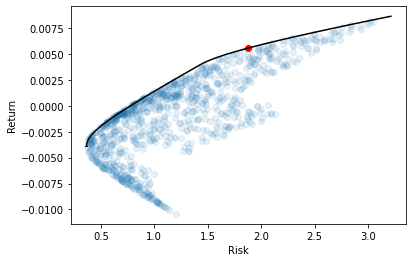

In [ ]:
plt.scatter(risks, returns, alpha=0.1);
plt.plot(optimized_risks, optimized_returns, c='black');
plt.scatter([sr_risk], [sr_return], c='red');
plt.xlabel("Risk");
plt.ylabel("Return");

In [ ]:
### use CVXOPT instead
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp, options

In [ ]:
G = matrix(0.0, (3,3))
G[::4] = -1.0
print(G)

[-1.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00 -1.00e+00]



In [ ]:
def my_minimize(mu, cov, target_return):
  mu2 = matrix(mu)
  cov2 = matrix(2*cov)
  q = matrix(0.0, (D, 1))
  # Gx <= h

  # makes identity matrix
  # G = matrix(0.0, (D, D))
  # G[::D+1] = -1.0
  G = matrix(-np.eye(D))
  h = matrix(0.5, (D, 1))
  # equivalent to
  # w(i) >= -h(i)

  # Ax = b
  # A = matrix(1.0, (1, D))
  A = np.vstack((
      np.ones(D),
      mu,
  ))
  A = matrix(A)
  b = matrix([1.0, target_return])

  res = qp(cov2, q, G, h, A, b)
  if res['status'] != 'optimal':
    print(res)
  return np.sqrt(res['primal objective']), np.array(res['x'])

In [ ]:
my_minimize(mean_return, cov, 0)

     pcost       dcost       gap    pres   dres
 0:  6.0563e-01 -2.0791e+00  3e+00  1e-16  3e+00
 1:  6.0361e-01  5.5580e-01  5e-02  2e-16  6e-02
 2:  6.0358e-01  6.0310e-01  5e-04  6e-17  6e-04
 3:  6.0358e-01  6.0357e-01  5e-06  1e-16  6e-06
 4:  6.0358e-01  6.0358e-01  5e-08  2e-16  6e-08
Optimal solution found.


(0.7769019761061723, array([[0.45364329],
        [0.1705053 ],
        [0.37585141]]))

In [ ]:
cvx_risks = []
for target in target_returns:
  risk, w = my_minimize(mean_return, cov, target)
  cvx_risks.append(risk)

     pcost       dcost       gap    pres   dres
 0:  1.6650e+00 -1.0298e+00  1e+01  2e+00  6e+00
 1:  1.5952e+00  1.1711e+00  9e-01  1e-01  4e-01
 2:  1.5815e+00  1.5741e+00  2e-02  2e-03  6e-03
 3:  1.5816e+00  1.5815e+00  2e-04  2e-05  6e-05
 4:  1.5816e+00  1.5816e+00  2e-06  2e-07  6e-07
 5:  1.5816e+00  1.5816e+00  3e-08  2e-09  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.5799e+00 -1.1827e+00  1e+01  2e+00  6e+00
 1:  1.5129e+00  1.0243e+00  9e-01  1e-01  3e-01
 2:  1.4983e+00  1.4245e+00  8e-02  9e-04  3e-03
 3:  1.4983e+00  1.4975e+00  8e-04  9e-06  3e-05
 4:  1.4983e+00  1.4983e+00  3e-05  2e-07  6e-07
 5:  1.4983e+00  1.4983e+00  3e-06  2e-09  5e-09
 6:  1.4983e+00  1.4983e+00  3e-07  2e-16  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.4973e+00 -1.3302e+00  1e+01  2e+00  6e+00
 1:  1.4331e+00  8.8932e-01  8e-01  7e-02  2e-01
 2:  1.4200e+00  1.3481e+00  7e-02  5e-04  1e-03
 3:  1.4199e+00  1.4128e

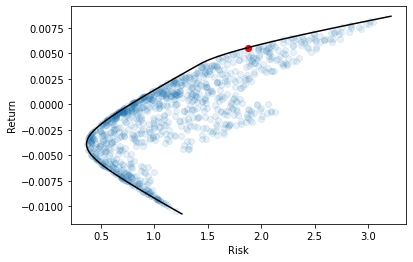

In [ ]:
plt.scatter(risks, returns, alpha=0.1);
plt.plot(cvx_risks, target_returns, c='black');
plt.scatter([sr_risk], [sr_return], c='red');
plt.xlabel("Risk");
plt.ylabel("Return");

In [ ]:
def my_minimize2(mu, cov, target_return):
  mu2 = matrix(mu)
  cov2 = matrix(2*cov)
  q = matrix(0.0, (D, 1))
  # Gx <= h

  # makes identity matrix
  # G = matrix(0.0, (D, D))
  # G[::D+1] = -1.0
  # G = matrix(-np.eye(D))
  # h = matrix(0.5, (D, 1))
  # equivalent to
  # w(i) >= -h(i)

  I = -np.eye(D)
  G = np.vstack((I, -mu))
  h = np.concatenate(([0.5]*D, [-target_return])).reshape(D+1, 1)
  G = matrix(G)
  h = matrix(h)


  # Ax = b
  # A = matrix(1.0, (1, D))
  A = np.vstack((
      np.ones(D),
  ))
  A = matrix(A)
  b = matrix([1.0])

  res = qp(cov2, q, G, h, A, b)
  if res['status'] != 'optimal':
    print(res)
  return np.sqrt(res['primal objective']), np.array(res['x'])

In [ ]:
cvx_risks = []
cvx_returns = []
for target in target_returns:
  risk, w = my_minimize2(mean_return, cov, target)
  cvx_risks.append(risk)
  cvx_returns.append(mean_return.dot(w))

     pcost       dcost       gap    pres   dres
 0:  1.7789e-01 -2.9230e+00  3e+00  6e-17  4e+00
 1:  1.3774e-01 -2.9666e-02  2e-01  5e-16  2e-01
 2:  1.3420e-01  1.3195e-01  2e-03  3e-16  2e-03
 3:  1.3420e-01  1.3418e-01  2e-05  2e-16  2e-05
 4:  1.3420e-01  1.3420e-01  2e-07  3e-16  2e-07
 5:  1.3420e-01  1.3420e-01  2e-09  6e-16  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.7789e-01 -2.9226e+00  3e+00  4e-16  4e+00
 1:  1.3774e-01 -2.9638e-02  2e-01  4e-16  2e-01
 2:  1.3420e-01  1.3195e-01  2e-03  1e-16  2e-03
 3:  1.3420e-01  1.3418e-01  2e-05  4e-16  2e-05
 4:  1.3420e-01  1.3420e-01  2e-07  3e-16  2e-07
 5:  1.3420e-01  1.3420e-01  2e-09  1e-16  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.7789e-01 -2.9222e+00  3e+00  2e-16  4e+00
 1:  1.3774e-01 -2.9610e-02  2e-01  4e-16  2e-01
 2:  1.3420e-01  1.3195e-01  2e-03  2e-16  1e-03
 3:  1.3420e-01  1.3418e-01  2e-05  2e-16  2e-05
 4:  1.3420e-01  1.3420e

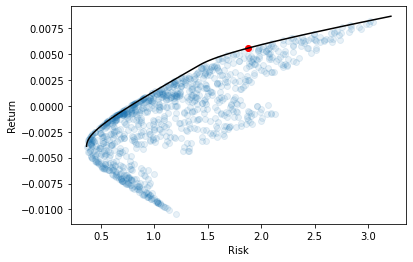

In [ ]:
plt.scatter(risks, returns, alpha=0.1);
plt.plot(cvx_risks, cvx_returns, c='black');
plt.scatter([sr_risk], [sr_return], c='red');
plt.xlabel("Risk");
plt.ylabel("Return");

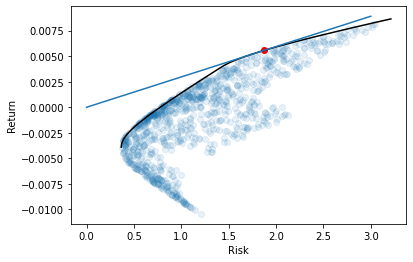

In [ ]:
plt.scatter(risks, returns, alpha=0.1);
plt.plot(cvx_risks, cvx_returns, c='black');
plt.scatter([sr_risk], [sr_return], c='red');

x1 = 0
y1 = 0
x2 = sr_risk
y2 = sr_return
x3 = 3
y3 = 3 * sr_return / sr_risk
plt.plot([x1, x2, x3], [y1, y2, y3]);

plt.xlabel("Risk");
plt.ylabel("Return");